<a href="https://colab.research.google.com/github/Acharyaniyam/INFO-INFO212/blob/main/Copy_of_INFO213_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Drexel University
## College of Computing and Informatics
## INFO 213: Data Science Programming II
## Assignment 4
## Due Date: Sunday, June 8, 2025
## This assignment counts for 15% of the final grade


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Question 1: Implement the Ensemble Method using Majority Vote for Classification

- In this question, you will implement and evaluate the ensemble method using majority vote for classifying the wine dataset in Scikit Learn.
- The ensemble should contain 4 individual classifiers: 1. Logistic Regression, 2. Decision Tree, 3. KNN, and 4. Multinomial Naive Bayes.
- Only use the `ash` and `hue` columns of the wine data.


Step 1: Load the wine data from sklearn.datasets using `load_wine()`. Extract only `ash` and `hue` columns for feature matrix $X$. Extract the corresponding labels as $y$.


In [ ]:
from sklearn.datasets import load_wine

In [ ]:
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)

X = df[['ash', 'hue']].values #getting only 'ash' and 'hue' columns

y = wine.target #target labels

print(X.shape)
print(y.shape)

(178, 2)
(178,)


Step 2: Split the data into training and test sets by 50:50 ratio.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state =42, stratify=y)
# Confirm the split
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (89, 2)
Test set shape: (89, 2)


Step 3: Creating 4 individual classifiers using default values: LogisticRegression, DecisionTree, MulitnomialNB, and KNN

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

clf1 = LogisticRegression(penalty='l2',
                         C=0.001,
                         solver = 'lbfgs',
                         random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
clf4 = MultinomialNB(alpha=1.0, fit_prior=True)

Step 4: Making pipelines for LogisticRegression and KNN with a StandardScaler step.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

In [ ]:
pipe1

Pipeline(steps=[['sc', StandardScaler()],
                ['clf', LogisticRegression(C=0.001, random_state=0)]])

In [ ]:
pipe3

Pipeline(steps=[['sc', StandardScaler()],
                ['clf', KNeighborsClassifier(n_neighbors=1)]])

Step 5: Fitting and evaluating the 4 individual classifiers/pipelines via 10-fold cross-validation. Using ACCURACY as scoring. **Print out the mean and standard deviation of the accuracy values across 10 folds for each individual classifier**.

In [ ]:
from sklearn.model_selection import cross_val_score

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3, clf4], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')
    print(f'Accuracy: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

Accuracy: 0.41 (+/- 0.06) [Logistic regression]
Accuracy: 0.59 (+/- 0.13) [Decision tree]
Accuracy: 0.63 (+/- 0.16) [KNN]
Accuracy: 0.41 (+/- 0.06) [MultinomialNB]


Step 6: Split the training set into 10 folds with stratification using `StratifiedKFold`.

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Step 7: Implement the function `collect_predictions(clfs, X_train, y_train, X_val)`:

In [ ]:
def collect_predictions(clfs, X_train, y_train, X_val):
    """
        Given a list of classifiers, clfs, collect the predictions of each individual classifier.
        For each classifier in the list, train the model on the training data and predict
        the labels on the valiation data X_val
        INPUT: clfs: a list of classifiers
               X_train, y_train: training data
               X_val: validation feature data
        OUTPUT: predictions: a nested lists of predicted labels
    """

    #### YOUR CODE HERE ######
    for clf in clfs:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        predictions.append(y_pred)

    return predictions









Step 8: Implement the function `majority_votes(predictions)`

In [ ]:
from scipy.stats import mode
def majority_votes(predictions):
    """
        Compute the majority votes across classifiers
        INPUT: predictions: a nested lists; each nested list contains the predicted labels by a classifier
        OUPTUT: majority_votes: a list of majority votes across classifiers
    """

    ##### YOUR CODE HERE ##########
    prediction_list = np.array(predictions).T #We are transposing to get the shape [n_samples][n_classifiers]

    majority_votes = mode(prediction_list, axis=1).mode.flatten().tolist()

    return majority_votes







Step 9: Evaluate ACCURACY of the ensemble of the 4 classifiers, [LogisticRegression, DecisionTreeClassifier, KNN, MultinomialNB] via the 10 folds. Compare to the accuracy values of individual classifiers at step 5. **Does the ensemble improve the accuracy values? Why or why not?**

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_ensemble(clfs, X_train, y_train):
    ensemble_accuracies = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Collect predictions from each classifier
        preds = []
        for clf in clfs:
            clf.fit(X_tr, y_tr)
            preds.append(clf.predict(X_val))

        # Compute majority vote
        y_pred_ensemble = majority_votes(preds)

        # Accuracy
        acc = accuracy_score(y_val, y_pred_ensemble)
        ensemble_accuracies.append(acc)

    return np.mean(ensemble_accuracies), np.std(ensemble_accuracies)

In [ ]:
clfs = [pipe1, clf2, pipe3, clf4]  # assuming these are defined
mean_acc, std_acc = evaluate_ensemble(clfs, X_train, y_train)

print(f'Ensemble Accuracy: {mean_acc:.2f} (+/- {std_acc:.2f})')

Ensemble Accuracy: 0.41 (+/- 0.06)


**Discussion**: No, the ensemble does not improve the accuracy values in this case. In fact, the ensemble accuracy (41%) is lower than two of the individual classifiers — Decision Tree (59%) and KNN (63%).

The ensemble performs poorly because two weak classifiers (Logistic Regression and MultinomialNB) dominate the vote, dragging down accuracy. Effective ensembles require strong, diverse models, but here, limited features (only ash and hue) and unsuitable models reduce overall performance.

Step 10: Train the 4 individual classifiers and the ensemble on the training data and evaluate their accuracy values on the test data. Compare the accuracy of the ensemble to that of the individual classifiers. **Does the ensemble improve the accuracy? Why or why not?**

**Discussion**:

In [ ]:
# Train individual classifiers
pipe1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
pipe3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predict on test data
pred1 = pipe1.predict(X_test)
pred2 = clf2.predict(X_test)
pred3 = pipe3.predict(X_test)
pred4 = clf4.predict(X_test)

In [ ]:
# Combine predictions and perform majority voting
predictions = np.array([pred1, pred2, pred3, pred4])
ensemble_preds = mode(predictions, axis=0).mode.flatten()

In [ ]:
# Evaluate accuracy
acc1 = accuracy_score(y_test, pred1)
acc2 = accuracy_score(y_test, pred2)
acc3 = accuracy_score(y_test, pred3)
acc4 = accuracy_score(y_test, pred4)
acc_ensemble = accuracy_score(y_test, ensemble_preds)

# Print results
print(f"Logistic Regression Accuracy: {acc1:.2f}")
print(f"Decision Tree Accuracy:      {acc2:.2f}")
print(f"KNN Accuracy:                {acc3:.2f}")
print(f"MultinomialNB Accuracy:      {acc4:.2f}")
print(f"Ensemble Accuracy:           {acc_ensemble:.2f}")

Logistic Regression Accuracy: 0.39
Decision Tree Accuracy:      0.56
KNN Accuracy:                0.71
MultinomialNB Accuracy:      0.39
Ensemble Accuracy:           0.39


Again, no the ensemble does not improve the accuracy. It is because 2 of the 4 classifier (Log Regression and MultinominalNB) perform poorly so their majority prediction bring down the other 2 better models. Similarly, majority vote failed as half the models are weak which overrides the correct predictions from stronger models. Moreover, limited features also influence the limitations in model performance.

# Question 2: Implement K-means Clustering Algorithm
In this question, you are asked to implement the K-means clustering algorithm.

The K-means clustering algorithm can be summarized by the following steps:
1. Randomly pick $k$ centroids from the examples as initial cluster centers.
2. Assign each example to the nearest centroid, $\mu^{(j)}, j\in\{1..k\}$.
3. Move the centroids to the center of the examples that were assigned to it.
4. Repeat steps 2 and 3 until the cluster assignments do not change or a user-defined tolerance or maximum number of iterations is reached.

To measure the distance between a point to a centroid, we calculate the squared Euclidean distance between two points $x$ and $y$ in $m$-dimensional space as follows:
\begin{equation}
 d(x, y)^2 = \Sigma_j^m(x_j-y_j)^2
\end{equation}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1: The file `kmeans_examdata.csv` contains example 2D data that will help you test the implemented K-means algorithm. Load the data into a Pandas DataFrame. It has 3 columns, `x1`, `x2`, and `label`. Plot the points represented by `(x1, x2)` and color the points according to `label`.   

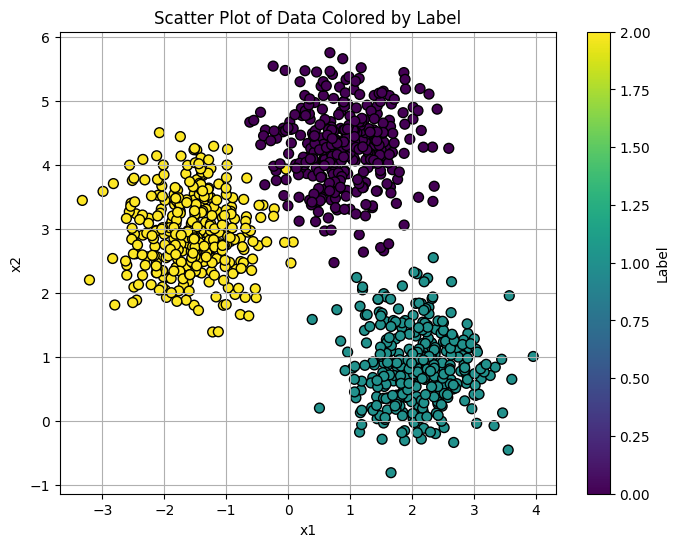

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/INFO213/kmeans_examdata(2) (1).csv')

# Plotting the points (x1, x2), colored by 'label'
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['x1'], df['x2'], c=df['label'], cmap='viridis', s=50, edgecolor='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter Plot of Data Colored by Label')
plt.colorbar(scatter, label='Label')
plt.grid(True)
plt.show()


Step 2: Implement the function `similarity(x, c)` that computes the squared Euclidean distance between two points `x` and `c`. Test the function on `x=[1, 2, 3]` and `c=[5, 7, 8]`. The result should be 66.

In [6]:
import numpy as np
def similarity(x, c):
    """
    calculate the squared Euclidean distance between two points
    Input: x: an mx1 vector representing the first point in m dimensional space
           c: an mx1 vector representing the second point in m dimensional space
    Output: a value that is the squared Euclidean distance between x and c
    """

    x = np.array(x)
    c = np.array(c)
    return np.sum((x - c) ** 2)




Squared Euclidean Distance: 66


In [7]:
x = np.array([1, 2, 3])
c= np.array([5, 7, 8])

In [8]:
similarity(x, c)

np.int64(66)

Step 3: Implement the function `nearestCentroid(x, centroids)` that
returns the index of the nearest centroid between a point `x` and the list of given centroids `centroids`.
Test the function on `x=[1, 2, 3]` and `centroids=[[2, 4, 6], [1, 1, 1], [5, 7, 8]]`. The result should be 1.

In [9]:
def nearestCentroid(x, centroids):
    """
    compute the index of nearest centroid between x and a list of centroids
    Input: x: an mx1 vector representing a point
           centroids: an Kxm matrix representing the list of K centroids
    Output: the index of the nearest centroid (return the first if there is a tie.)
    """

    distances = [similarity(x, centroid) for centroid in centroids]
    return np.argmin(distances)



In [10]:
x = [1, 2, 3]
centroids=[[2, 4, 6], [1, 1, 1], [5, 7, 8]]

In [11]:
nearestCentroid(x, centroids)

np.int64(1)

Step 4: Implement the function `findNearestCentroids(X, centroids)` that finds the indices of nearest centroids between the points in `X` and the list of centroids. This
function takes the data matrix `X` and the locations of all centroids inside `centroids` and should output a one-dimensional array `idx` that holds the index (a value in $\{1..K\}$, where $K$ is total number of centroids) of the nearest centroid to every point in `X`. Test the function on `X=[[1, 2, 3], [2, 4, 5], [5, 6, 7], [7, 8, 9]] ` and `centroids=[[2, 4, 6], [1, 1, 1], [5, 7, 8]]`. The result should be `[1, 0, 2, 2]`.

In [12]:
def findNearestCentroids(X, centroids):
    """
    compute the indices of nearest centroids between points in X and a list of centroids
    Input: X: an nxm matrix representing n points
           centroids: an Kxm representing the list of K centroids
    Output: the indices of the nearest centroids (return the first if there is a tie.)
    """

    idx = []
    for x in X:
        distances = [similarity(x, centroid) for centroid in centroids]
        idx.append(np.argmin(distances))
    return np.array(idx)





In [13]:
X=[[1, 2, 3], [2, 4, 5], [5, 6, 7], [7, 8, 9]]
centroids=[[2, 4, 6], [1, 1, 1], [5, 7, 8]]

In [14]:
findNearestCentroids(X, centroids)

array([1, 0, 2, 2])

Step 5: Implement the function `computeCentroids(X, labels)` to compute the new centroids of clusters. Given assignments of every point in `X` to a cluster indicated by `labels` (values in $\{1..K\}$, where $K$ is the number of clusters), the function computes the new centroid of a cluster $k$ as:
\begin{equation}
\mathbf{\mu}_k = \frac{1}{|cluster_k|}\Sigma_i\mathbf{x}^{(i)}
\end{equation}
where, $|cluster_k|$ is the size of the cluter $k$, $\mathbf{x}^{(i)}$ is the $i$_th point in cluster $k$. Test the function on `X= [[1, 2, 3], [2, 4, 5], [5, 6, 7], [7, 8, 9]]`
and `labels = [1, 0, 2, 2]`. The result should be `array([[2., 4., 5.], [1., 2., 3.], [6., 7., 8.]])`.

In [15]:
def computeCentroids(X, labels):
    """
    compute new centroids for clusters indicated by labels
    Input: X: an nxm matrix representing n points in m dimensional space
           labels: an nx1 vectors representing K clusters
    Output: an Kxm matrix representing the K new centroids of the K clusters
    """

    X = np.array(X)
    labels = np.array(labels)
    K = np.max(labels) + 1  # number of clusters
    centroids = []

    for k in range(K):
        cluster_points = X[labels == k]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)

    return np.array(centroids)



In [16]:
X= [[1, 2, 3], [2, 4, 5], [5, 6, 7], [7, 8, 9]]
labels = [1, 0, 2, 2]

In [17]:
computeCentroids(X, labels)

array([[2., 4., 5.],
       [1., 2., 3.],
       [6., 7., 8.]])

Step 6: Implement the function `randomInitialization(n, K)` that randomly picks up `K` points from a list of `n` numbers. Test the function on `n=100` and `K=3`.

In [18]:
def randomInitialization(n, K):
  """
  Randomly picks up K different points from a list of n numbers.
  Input: n: the number of numbers in the list
         K: the number of points to be picked up
  Output: a list of the indices of the picked up different points
  """

  return random.sample(range(n), K)




In [19]:
randomInitialization(100, 3)

[85, 90, 37]

Step 7: Implement the function `stopCondition(old_centroids, new_centroids, iteration, max_iterations, tol=1e-4)` that returns whether the K-means algorithm should stop. Test the function on `old_centroids =[[2, 4, 6], [1, 1, 1], [5, 7, 8]]`,
`new_centroids = [[2., 4., 5.], [1., 2., 3.], [6., 7., 8.]]`, and some values of other parameters. Verify the results are correct.

In [20]:
def stopCondition(old_centroids, new_centroids, iteration, max_iterations, tol):
    """
    Stop condition for K-means clustering.
    Input:
        old_centroids: Centroids from the previous iteration
        new_centroids: Centroids from the current iteration
        iteration: Current iteration number
        max_iterations: Maximum number of iterations allowed
        tol: Tolerance level for centroid change

    Output: a boolean value True if the stop condition is met, False otherwise.
    """

    ##### YOUR CODE HERE ##########

    # Check if the maximum number of iterations is reached
    old = np.array(old_centroids)
    new = np.array(new_centroids)

    if iteration >= max_iterations:
        return True

    # Check if all centroid shifts are within the tolerance
    diff = np.linalg.norm(old - new)
    return diff < tol





In [21]:
old_centroids =[[2, 4, 6], [1, 1, 1], [5, 7, 8]]
new_centroids = [[2., 4., 5.], [1., 2., 3.], [6., 7., 8.]]

In [22]:
stopCondition(old_centroids, new_centroids, 5, 10, 1)

np.False_

Step 8: Now implement the `kmeans(X, K, max_iterations, tol)` algorithm by calling the functions that have been implemented above. The K-means function should return the final cluster labels of the input points in `X` and the centroids of the `K` clusters. Test the function on the example 2D data on `K=3`, `max_iterations=100`, and `tol=0.01`. Assign the labels to `labels` and centroids to `centroids`.

In [39]:
def kmeans(X, K, max_iterations, tol):
    """
    K-means algorithm that clusters the input data in X to K clusters.
    Input: X: an nxm matrix representing n points in m dimenstional space
           K: the number of clusters
           max_interations: a stop condition on number of iterations
           tol: a stop condition on centroid changes
    Output: labels: an nx1 vector representing the cluster labels for the input points
            centroids: an Kxm matrix representing the centroids of the K clusters
    """

    ##### YOUR CODE HERE ##########

    X = np.array(X)  # Ensure NumPy array
    indices = randomInitialization(len(X), K)
    centroids = X[indices]

    for i in range(max_iterations):
        labels = findNearestCentroids(X, centroids)
        new_centroids = computeCentroids(X, labels)

        if stopCondition(centroids, new_centroids, i, max_iterations, tol):
            break
        centroids = new_centroids

    return labels, centroids






In [40]:
df.iloc[:, :2].values

array([[-1.09510311,  2.76883068],
       [ 1.54632313,  4.212973  ],
       [-1.51086098,  3.02795241],
       ...,
       [ 1.06948835,  0.65402058],
       [-2.13052613,  2.42495237],
       [ 1.48677436,  1.04432973]])

In [41]:
labels, centroids = kmeans(df.iloc[:, :2].values, 3, 100, 0.01)

Step 9: Compute the accuracy of the results of the `kmeans()` function comparing to the true labels in the original 2D data. **Discuss the results with outlining how to improve.**

In [44]:
from sklearn.metrics import accuracy_score
from scipy.stats import mode


def compute_kmeans_accuracy(true_labels, predicted_labels):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    labels = np.zeros_like(predicted_labels)

    for i in np.unique(predicted_labels):
        mask = (predicted_labels == i)
        if np.any(mask):
            labels[mask] = mode(true_labels[mask], keepdims=False).mode

    return accuracy_score(true_labels, labels)

In [45]:
# Run K-means on the 2D feature data
X = df.iloc[:, :2].values
true_labels = df['label'].values

# Perform clustering
labels_pred, centroids = kmeans(X, K=3, max_iterations=100, tol=0.01)


acc = compute_kmeans_accuracy(true_labels, labels_pred)
print(f"K-means Clustering Accuracy: {acc * 100:.2f}%")


K-means Clustering Accuracy: 99.80%


**Discussion:**

K-means achieved 99.80% accuracy, showing that the clusters in the dataset are well-separated. The high accuracy also suggests that the initial centroids were selected effectively. To ensure consistent results, the algorithm can be run multiple times with different starting points.

Step 10: Plot the original 2D data colored by the labels computered by the `kmeans()` function. Also, show the centroids on the plot. **Discuss the results: is the clustering good? why or why not?**

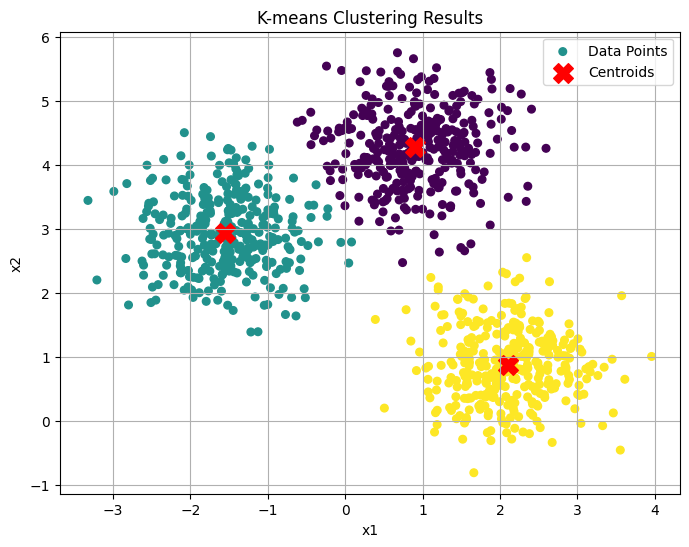

In [46]:
import matplotlib.pyplot as plt

labels_pred, centroids = kmeans(df.iloc[:, :2].values, K=3, max_iterations=100, tol=0.01)

plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels_pred, cmap='viridis', s=30, label='Data Points')
plt.scatter(*zip(*centroids), c='red', s=200, marker='X', label='Centroids')
plt.title('K-means Clustering Results')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

**Discussion:**

Yes, the clustering is very good. The data points are clearly separated into three distinct groups, and the centroids (red Xs) are accurately positioned at the center of each cluster. The clean boundaries and minimal overlap between groups further confirm the quality of the clustering.